<a href="https://colab.research.google.com/github/saikumarreddykorsapati-source/DSM_Challenge_3/blob/main/DSM_Challenge_3_Social_Distance_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Config variable values**

In [ ]:
MIN_CONF = 0.3
NMS_THRESH = 0.3
MIN_DISTANCE = 80

### **Creating the People Detection Function**

In [ ]:
import numpy as np
import cv2

def detect_people(frame, net, ln, personIdx=0):
	(H, W) = frame.shape[:2]
	results = []
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
	net.setInput(blob)
	layerOutputs = net.forward(ln)
	boxes = []
	centroids = []
	confidences = []
	for output in layerOutputs:
		for detection in output:
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]
			if classID == personIdx and confidence > MIN_CONF:
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))
				boxes.append([x, y, int(width), int(height)])
				centroids.append((centerX, centerY))
				confidences.append(float(confidence))
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, MIN_CONF, NMS_THRESH)
	if len(idxs) > 0:
		for i in idxs.flatten():
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])
			r = (confidences[i], (x, y, x + w, y + h), centroids[i])
			results.append(r)

	return results

### **Grab frames from video and make prediction measuring distances of detected people**

[INFO] loading YOLO from disk...
[INFO] accessing video stream...


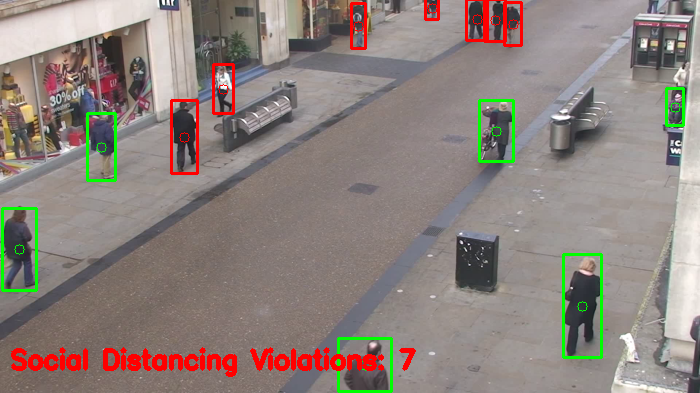

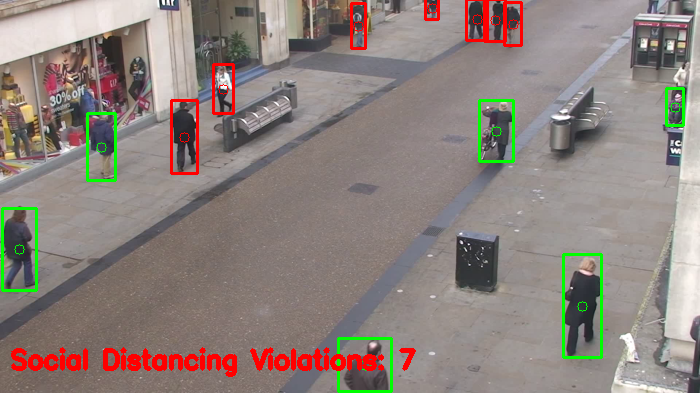

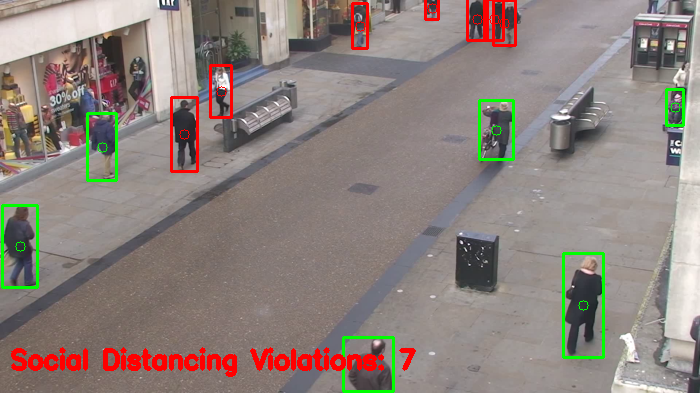

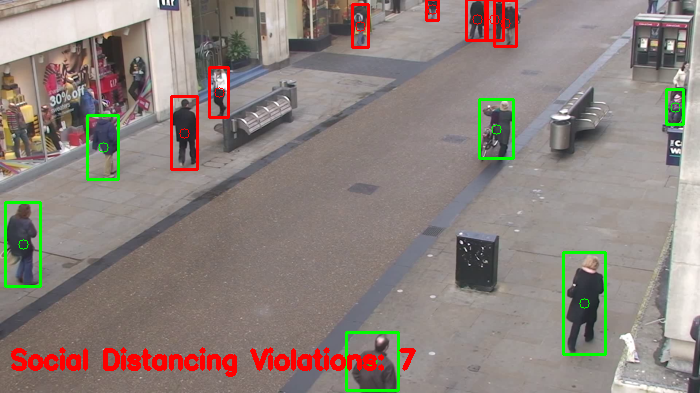

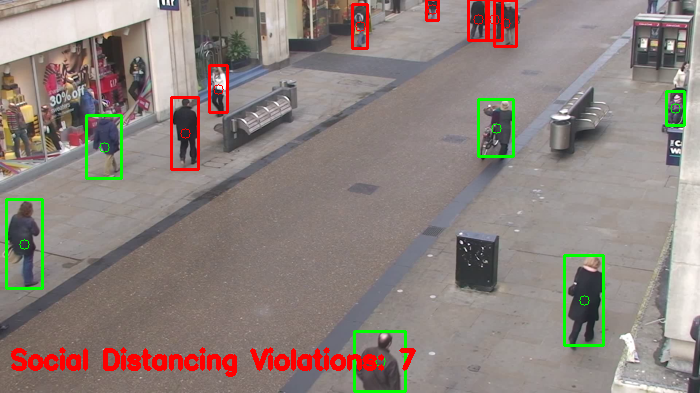

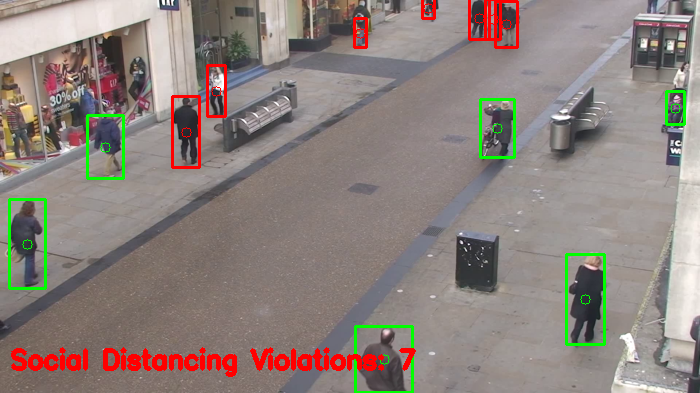

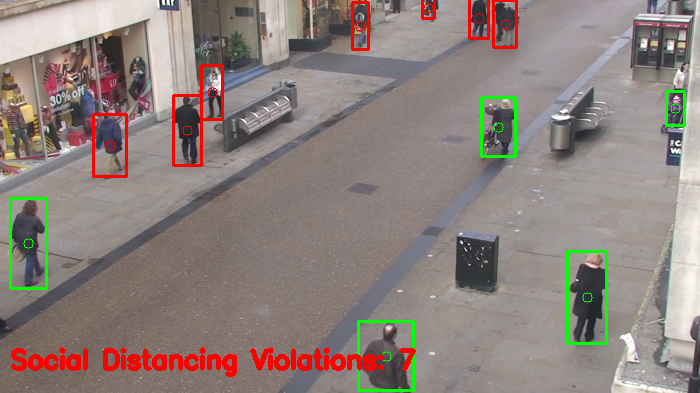

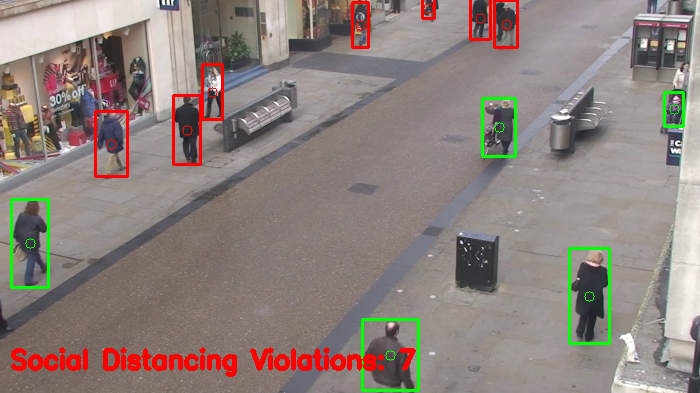

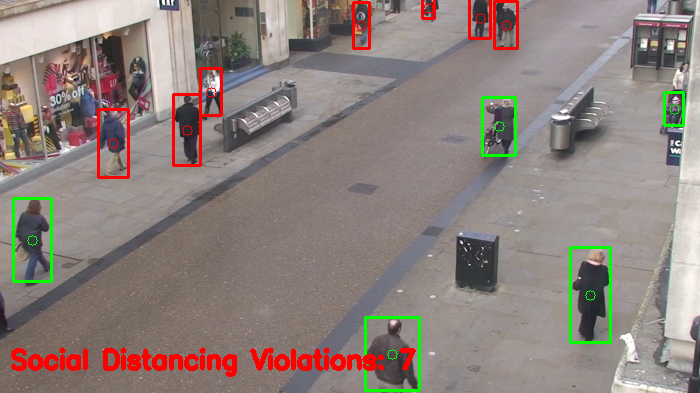

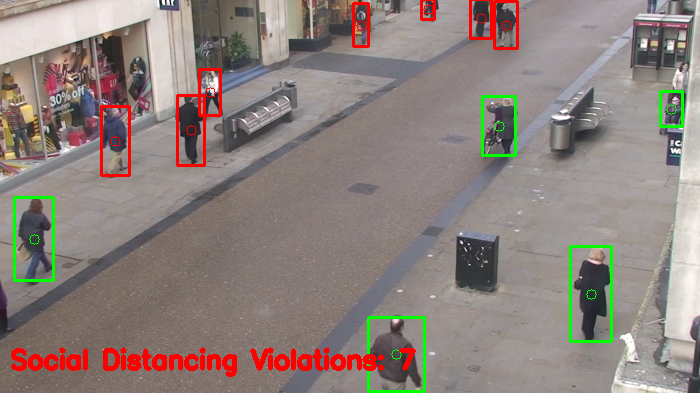

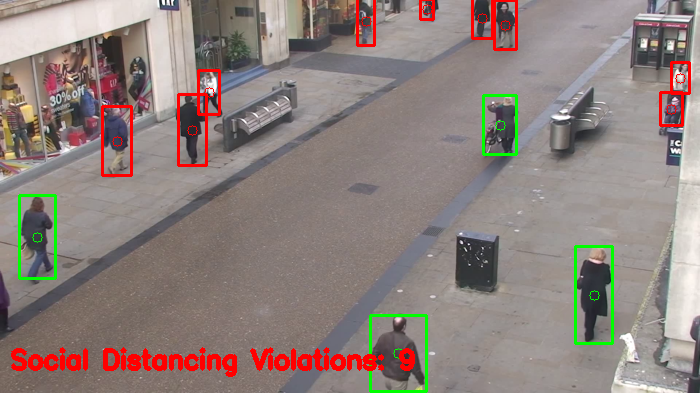

KeyboardInterrupt: ignored

In [ ]:
from google.colab.patches import cv2_imshow
from scipy.spatial import distance as dist
import numpy as np
import argparse
import imutils
import cv2
import os

ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", type=str, default="",
	help="path to (optional) input video file")
ap.add_argument("-o", "--output", type=str, default="",
	help="path to (optional) output video file")
ap.add_argument("-d", "--display", type=int, default=1,
	help="whether or not output frame should be displayed")
args = vars(ap.parse_args(["--input","/content/drive/My Drive/DSM_Challenge_3_Social-Distancing-Detection/assets/pedestrians.mp4","--output","my_output.avi","--display","1"]))

labelsPath = os.path.sep.join(["/content/drive/My Drive/DSM_Challenge_3_Social-Distancing-Detection/yolo-coco/coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

weightsPath = os.path.sep.join(["/content/drive/My Drive/DSM_Challenge_3_Social-Distancing-Detection/yolo-coco/yolov3.weights"])
configPath = os.path.sep.join(["/content/drive/My Drive/DSM_Challenge_3_Social-Distancing-Detection/yolo-coco/yolov3.cfg"])

print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

print("[INFO] accessing video stream...")
vs = cv2.VideoCapture(args["input"] if args["input"] else 0)
writer = None

while True:
	(grabbed, frame) = vs.read()
	if not grabbed:
		break

	frame = imutils.resize(frame, width=700)
	results = detect_people(frame, net, ln,
		personIdx=LABELS.index("person"))

	violate = set()

	if len(results) >= 2:
		centroids = np.array([r[2] for r in results])
		D = dist.cdist(centroids, centroids, metric="euclidean")
		for i in range(0, D.shape[0]):
			for j in range(i + 1, D.shape[1]):
				if D[i, j] < MIN_DISTANCE:
					violate.add(i)
					violate.add(j)

	for (i, (prob, bbox, centroid)) in enumerate(results):
		(startX, startY, endX, endY) = bbox
		(cX, cY) = centroid
		color = (0, 255, 0)

		if i in violate:
			color = (0, 0, 255)

		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
		cv2.circle(frame, (cX, cY), 5, color, 1)

	text = "Social Distancing Violations: {}".format(len(violate))
	cv2.putText(frame, text, (10, frame.shape[0] - 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)

	if args["display"] > 0:
		cv2_imshow(frame)
		key = cv2.waitKey(1) & 0xFF

		if key == ord("q"):
			break

	if args["output"] != "" and writer is None:
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 25,
			(frame.shape[1], frame.shape[0]), True)

	if writer is not None:
		writer.write(frame)